# Data@ANZ - ANZ Virtual Internship
## Predictive Analytics - Task 2

<b>Roshan Wahane (Master of Data Science, Monash University)<br>
Email: [Redacted]<br>
Mobile: [Redacted]<br>
LinkedIn: https://www.linkedin.com/in/roshan-wahane/<br>
GitHub: https://github.com/roshanwahane<br>
Tableau: https://public.tableau.com/profile/roshan.wahane#!/<br></b>

## Table of Contents

* [Project objective](#sec_1)
* [Loading libraries and data](#sec_2)
* [Data cleaning](#sec_3)
* [Derive attributes](#sec_4)
* [Calculate correlation, heatmap and scatter plot](#sec_5)
* [One hot encoding](#sec_6)
* [Linear regression model](#sec_7)
* [Decision tree regression model](#sec_8)
* [Conclusion](#sec_9)

## 1. Project objective <a class="anchor" id="sec_1"></a>

<b>Predict annual salary</b><br>
Explore correlations between annual salary and various customer attributes. Some of the attributes are already available but we will work on deriving more attributes from the dataset.<br> 
We will further calculate and visualise correlation between different attributes in the dataset.<br>
Once we have the dataset ready, we will begin to build a linear regression model followed by decision-based regression tree to predict annual salary of customers in the dataset.<br>
We will conclude the project by comparing the performance of two models.

## 2. Loading libraries and data <a class="anchor" id="sec_2"></a>

### 2.1 Importing required libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.point import Point
import pgeocode
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz

### 2.2 Setting display options

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

### 2.3 Reading the excel file with raw data

In [3]:
df = pd.read_excel("ANZ synthesised transaction dataset.xlsx")

### 2.4 Performing regular checks to gain general insights about the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
status               12043 non-null object
card_present_flag    7717 non-null float64
bpay_biller_code     885 non-null object
account              12043 non-null object
currency             12043 non-null object
long_lat             12043 non-null object
txn_description      12043 non-null object
merchant_id          7717 non-null object
merchant_code        883 non-null float64
first_name           12043 non-null object
balance              12043 non-null float64
date                 12043 non-null datetime64[ns]
gender               12043 non-null object
age                  12043 non-null int64
merchant_suburb      7717 non-null object
merchant_state       7717 non-null object
extraction           12043 non-null object
amount               12043 non-null float64
transaction_id       12043 non-null object
country              12043 non-null object
customer_id          12043 n

In [5]:
df.describe()

,card_present_flag,merchant_code,balance,age,amount
count,7717.000000,883.0,12043.000000,12043.000000,12043.000000
mean,0.802644,0.0,14704.195553,30.582330,187.933588
std,0.398029,0.0,31503.722652,10.046343,592.599934
min,0.000000,0.0,0.240000,18.000000,0.100000
25%,1.000000,0.0,3158.585000,22.000000,16.000000
50%,1.000000,0.0,6432.010000,28.000000,29.000000
75%,1.000000,0.0,12465.945000,38.000000,53.655000
max,1.000000,0.0,267128.520000,78.000000,8835.980000


In [6]:
df.shape

(12043, 23)

In [7]:
df.isnull().sum()

status               0    
card_present_flag    4326 
bpay_biller_code     11158
account              0    
currency             0    
long_lat             0    
txn_description      0    
merchant_id          4326 
merchant_code        11160
first_name           0    
balance              0    
date                 0    
gender               0    
age                  0    
merchant_suburb      4326 
merchant_state       4326 
extraction           0    
amount               0    
transaction_id       0    
country              0    
customer_id          0    
merchant_long_lat    4326 
movement             0    
dtype: int64

## 3. Data cleaning <a class="anchor" id="sec_3"></a>

In [8]:
df[['customer_long','customer_lat']] = df.long_lat.str.split(" ",expand=True,)

In [9]:
df[['merchant_long','merchant_lat']] = df.merchant_long_lat.str.split(" ",expand=True,)

In [10]:
df['customer_lat'] = df['customer_lat'].astype(float)

In [11]:
df['customer_long'] = df['customer_long'].astype(float)

In [12]:
df['extraction'] =  pd.to_datetime(df['extraction'])

In [13]:
df['date'] =  pd.to_datetime(df['date'], format = '%d%m%y')

In [14]:
len(df['date'].unique().tolist())

91

In [15]:
# Drop unnecessary columns 
df = df.drop(['bpay_biller_code', 'long_lat', 'merchant_code', 'merchant_long_lat', 'currency', 'status',
              'card_present_flag', 'movement'], axis=1)

In [16]:
df.columns

Index(['account', 'txn_description', 'merchant_id', 'first_name', 'balance', 'date', 'gender', 'age', 'merchant_suburb', 'merchant_state', 'extraction', 'amount', 'transaction_id', 'country', 'customer_id', 'customer_long', 'customer_lat', 'merchant_long', 'merchant_lat'], dtype='object')

In [17]:
len(df.columns)

19

In [18]:
# detect incorrect latitude
remove_cust = set()
for i, j in df.iterrows():
    if (-90 >j['customer_lat'] <90):
        remove_cust.add(j['customer_id'])
    

In [19]:
remove_cust

{'CUS-1617121891'}

In [20]:
df = df[~df['customer_id'].isin(remove_cust)]

In [21]:
df.head()

,account,txn_description,merchant_id,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,customer_long,customer_lat,merchant_long,merchant_lat
0,ACC-1598451071,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01 01:01:15+00:00,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.41,-27.95,153.38,-27.99
1,ACC-1598451071,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01 01:13:45+00:00,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,153.41,-27.95,151.21,-33.87
2,ACC-1222300524,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01 01:26:15+00:00,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.23,-33.94,151.21,-33.87
3,ACC-1037050564,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01 01:38:45+00:00,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.10,-27.66,153.05,-26.68
4,ACC-1598451071,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01 01:51:15+00:00,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.41,-27.95,153.44,-28.06


## 4. Derive attributes <a class="anchor" id="sec_4"></a>

### 4.1 Calculate annual salary

In [22]:
df_salary = df.loc[df['txn_description'].isin(['PAY/SALARY'])]

In [23]:
len(df_salary.customer_id.unique())

99

In [24]:
df_salary.shape

(876, 19)

In [25]:
df_salary.head()

,account,txn_description,merchant_id,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,customer_long,customer_lat,merchant_long,merchant_lat
50,ACC-588564840,PAY/SALARY,NaN,Isaiah,8342.11,2018-08-01,M,23,NaN,NaN,2018-08-01 11:00:00+00:00,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,CUS-1462656821,151.27,-33.76,NaN,NaN
61,ACC-1650504218,PAY/SALARY,NaN,Marissa,2040.58,2018-08-01,F,23,NaN,NaN,2018-08-01 12:00:00+00:00,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,CUS-2500783281,145.01,-37.93,NaN,NaN
64,ACC-3326339947,PAY/SALARY,NaN,Eric,3158.51,2018-08-01,M,22,NaN,NaN,2018-08-01 12:00:00+00:00,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,CUS-326006476,151.18,-33.80,NaN,NaN
68,ACC-3541460373,PAY/SALARY,NaN,Jeffrey,2517.66,2018-08-01,M,24,NaN,NaN,2018-08-01 13:00:00+00:00,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,CUS-1433879684,145.00,-37.83,NaN,NaN
70,ACC-2776252858,PAY/SALARY,NaN,Kristin,2271.79,2018-08-01,F,43,NaN,NaN,2018-08-01 13:00:00+00:00,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,CUS-4123612273,144.95,-37.76,NaN,NaN


In [26]:
freq = df_salary.groupby(['customer_id','amount']).count()['transaction_id'].to_frame()

In [27]:
freq = freq.reset_index()

In [28]:
freq.columns

Index(['customer_id', 'amount', 'transaction_id'], dtype='object')

In [29]:
freq = freq.rename(columns={'transaction_id':'num_times_paid', 'amount':'salary_amount'})

In [30]:
df_salary.shape

(876, 19)

In [31]:
df_salary = pd.merge(df_salary, freq, on='customer_id',how='left')

In [32]:
df_salary.shape

(876, 21)

In [33]:
# Assumption: - Salary amount is same every pay cycle. 

In [34]:
df_salary.groupby(['customer_id','date','amount']).count()['transaction_id'].head(30)

customer_id     date        amount 
CUS-1005756958  2018-08-07  970.47     1
                2018-08-14  970.47     1
                2018-08-21  970.47     1
                2018-08-28  970.47     1
                2018-09-04  970.47     1
                2018-09-11  970.47     1
                2018-09-18  970.47     1
                2018-09-25  970.47     1
                2018-10-02  970.47     1
                2018-10-09  970.47     1
                2018-10-16  970.47     1
                2018-10-23  970.47     1
                2018-10-30  970.47     1
CUS-1117979751  2018-08-06  3578.65    1
                2018-08-20  3578.65    1
                2018-09-03  3578.65    1
                2018-09-17  3578.65    1
                2018-10-01  3578.65    1
                2018-10-15  3578.65    1
                2018-10-29  3578.65    1
CUS-1140341822  2018-08-10  1916.51    1
                2018-08-24  1916.51    1
                2018-09-07  1916.51    1
                2018-

In [35]:
# We can see above that our assumption is correct as customers are getting paid the same amount every pay cycle.

In [36]:
def cal_salary(df_sal, df_orig):
    num_days = len(df_orig.date.unique())
    freq = num_days/df_sal['num_times_paid']
    annual = (df_sal['salary_amount']/freq)*364
    return annual

# Annual salary calculation: - We have 91 days in the dataset. 
# The goal is to calculate each customer's daily wage then multiply that by 364 to calculate for the whole year.
# So first we calculated how many times did the customer get paid in these 91 days (num_times_paid).
# To calculate the customer's daily wage we then divided 91 days by the pay_cycle.
# For example: - if the customer got paid 14 times in the 91 days then we can conclude that they are getting
# paid weekly (91/14 = 6.5). So if we divide their pay with the frequency we will get their daily pay.
# We can then multiply the daily pay with 364 to get their annual income.

In [37]:
df_salary['annual_salary'] = cal_salary(df_salary, df)

In [38]:
df_salary.head()

,account,txn_description,merchant_id,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,customer_long,customer_lat,merchant_long,merchant_lat,salary_amount,num_times_paid,annual_salary
0,ACC-588564840,PAY/SALARY,NaN,Isaiah,8342.11,2018-08-01,M,23,NaN,NaN,2018-08-01 11:00:00+00:00,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,CUS-1462656821,151.27,-33.76,NaN,NaN,3903.95,7,109310.60
1,ACC-1650504218,PAY/SALARY,NaN,Marissa,2040.58,2018-08-01,F,23,NaN,NaN,2018-08-01 12:00:00+00:00,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,CUS-2500783281,145.01,-37.93,NaN,NaN,1626.48,14,91082.88
2,ACC-3326339947,PAY/SALARY,NaN,Eric,3158.51,2018-08-01,M,22,NaN,NaN,2018-08-01 12:00:00+00:00,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,CUS-326006476,151.18,-33.80,NaN,NaN,983.36,14,55068.16
3,ACC-3541460373,PAY/SALARY,NaN,Jeffrey,2517.66,2018-08-01,M,24,NaN,NaN,2018-08-01 13:00:00+00:00,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,CUS-1433879684,145.00,-37.83,NaN,NaN,1408.08,7,39426.24
4,ACC-2776252858,PAY/SALARY,NaN,Kristin,2271.79,2018-08-01,F,43,NaN,NaN,2018-08-01 13:00:00+00:00,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,CUS-4123612273,144.95,-37.76,NaN,NaN,1068.04,14,59810.24


### 4.2 Calculate customer location

In [39]:
# Assumption is that the customer would make most transactions nearby to where they live.
# So we have to find a merchant for each customer where they have made most transactions
# and since we have merchant location. We can map the same location to the customer.

In [40]:
# KERNEL KEEPS DYING ON THIS COMMAND
#df.groupby(['customer_id','first_name','merchant_suburb','merchant_state']).count()['transaction_id']#.head(250)

In [41]:
# Unfortunately this strategy wont work as some customers have same number of transactions from two different states.
# For example: - (CUS-1196156254, Jessica, 16 transactions in SA and WA each)
# We will need to figure out different approach to get address of customers based on their coordinates.

In [42]:
df_salary['customer_geom'] = df_salary['customer_lat'].map(str) + ',' + df_salary['customer_long'].map(str)
df_salary['customer_geom'][0]

'-33.76,151.27'

In [43]:
df_salary.head()

,account,txn_description,merchant_id,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,customer_long,customer_lat,merchant_long,merchant_lat,salary_amount,num_times_paid,annual_salary,customer_geom
0,ACC-588564840,PAY/SALARY,NaN,Isaiah,8342.11,2018-08-01,M,23,NaN,NaN,2018-08-01 11:00:00+00:00,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,CUS-1462656821,151.27,-33.76,NaN,NaN,3903.95,7,109310.60,"-33.76,151.27"
1,ACC-1650504218,PAY/SALARY,NaN,Marissa,2040.58,2018-08-01,F,23,NaN,NaN,2018-08-01 12:00:00+00:00,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,CUS-2500783281,145.01,-37.93,NaN,NaN,1626.48,14,91082.88,"-37.93,145.01"
2,ACC-3326339947,PAY/SALARY,NaN,Eric,3158.51,2018-08-01,M,22,NaN,NaN,2018-08-01 12:00:00+00:00,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,CUS-326006476,151.18,-33.80,NaN,NaN,983.36,14,55068.16,"-33.8,151.18"
3,ACC-3541460373,PAY/SALARY,NaN,Jeffrey,2517.66,2018-08-01,M,24,NaN,NaN,2018-08-01 13:00:00+00:00,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,CUS-1433879684,145.00,-37.83,NaN,NaN,1408.08,7,39426.24,"-37.83,145.0"
4,ACC-2776252858,PAY/SALARY,NaN,Kristin,2271.79,2018-08-01,F,43,NaN,NaN,2018-08-01 13:00:00+00:00,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,CUS-4123612273,144.95,-37.76,NaN,NaN,1068.04,14,59810.24,"-37.76,144.95"


In [44]:
# We will be using Geocode API to get customer postcode from their coordinates. We will then use the derived postcode
# to derive State for each customer.

In [45]:
locator = Nominatim(user_agent='myGeocoder', timeout=10)

In [46]:
def get_postcode(row):
    pos = row['customer_geom']
    locations = locator.reverse(Point(pos))
    address = locations.raw
    postcode_no = address.get('address').get('postcode')
    return postcode_no

In [47]:
df_salary['postcode'] = df_salary.apply(get_postcode, axis=1)

In [48]:
df_salary.head()

,account,txn_description,merchant_id,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,customer_long,customer_lat,merchant_long,merchant_lat,salary_amount,num_times_paid,annual_salary,customer_geom,postcode
0,ACC-588564840,PAY/SALARY,NaN,Isaiah,8342.11,2018-08-01,M,23,NaN,NaN,2018-08-01 11:00:00+00:00,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,CUS-1462656821,151.27,-33.76,NaN,NaN,3903.95,7,109310.60,"-33.76,151.27",2100
1,ACC-1650504218,PAY/SALARY,NaN,Marissa,2040.58,2018-08-01,F,23,NaN,NaN,2018-08-01 12:00:00+00:00,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,CUS-2500783281,145.01,-37.93,NaN,NaN,1626.48,14,91082.88,"-37.93,145.01",3187
2,ACC-3326339947,PAY/SALARY,NaN,Eric,3158.51,2018-08-01,M,22,NaN,NaN,2018-08-01 12:00:00+00:00,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,CUS-326006476,151.18,-33.80,NaN,NaN,983.36,14,55068.16,"-33.8,151.18",2067
3,ACC-3541460373,PAY/SALARY,NaN,Jeffrey,2517.66,2018-08-01,M,24,NaN,NaN,2018-08-01 13:00:00+00:00,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,CUS-1433879684,145.00,-37.83,NaN,NaN,1408.08,7,39426.24,"-37.83,145.0",3121
4,ACC-2776252858,PAY/SALARY,NaN,Kristin,2271.79,2018-08-01,F,43,NaN,NaN,2018-08-01 13:00:00+00:00,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,CUS-4123612273,144.95,-37.76,NaN,NaN,1068.04,14,59810.24,"-37.76,144.95",3055


In [49]:
df_salary.shape

(876, 24)

In [50]:
df_salary.isnull().sum()

account            0  
txn_description    0  
merchant_id        876
first_name         0  
balance            0  
date               0  
gender             0  
age                0  
merchant_suburb    876
merchant_state     876
extraction         0  
amount             0  
transaction_id     0  
country            0  
customer_id        0  
customer_long      0  
customer_lat       0  
merchant_long      876
merchant_lat       876
salary_amount      0  
num_times_paid     0  
annual_salary      0  
customer_geom      0  
postcode           27 
dtype: int64

In [51]:
nomi = pgeocode.Nominatim('au')
c = nomi.query_postal_code(df_salary['postcode'][6])

In [52]:
c

postal_code       5048                                                         
country code      AU                                                           
place_name        North Brighton, Dover Gardens, Hove, South Brighton, Brighton
state_name        South Australia                                              
state_code        SA                                                           
county_name       SA SUBS NEAR 1                                               
county_code       NaN                                                          
community_name    NaN                                                          
community_code    NaN                                                          
latitude         -35.0055                                                      
longitude         138.526                                                      
accuracy          4                                                            
Name: 0, dtype: object

In [53]:
def nomi_state(row):
    x = nomi.query_postal_code(row['postcode'])
    y = x['state_name']
    return y

In [54]:
def nomi_city(row):
    x = nomi.query_postal_code(row['postcode'])
    y = x['county_name']
    return y

In [55]:
df_salary['state'] = df_salary.apply(nomi_state, axis=1)

In [56]:
df_salary['city/suburb'] = df_salary.apply(nomi_city, axis=1)

In [57]:
df_salary.head()

,account,txn_description,merchant_id,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,customer_long,customer_lat,merchant_long,merchant_lat,salary_amount,num_times_paid,annual_salary,customer_geom,postcode,state,city/suburb
0,ACC-588564840,PAY/SALARY,NaN,Isaiah,8342.11,2018-08-01,M,23,NaN,NaN,2018-08-01 11:00:00+00:00,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,CUS-1462656821,151.27,-33.76,NaN,NaN,3903.95,7,109310.60,"-33.76,151.27",2100,New South Wales,WARRINGAH
1,ACC-1650504218,PAY/SALARY,NaN,Marissa,2040.58,2018-08-01,F,23,NaN,NaN,2018-08-01 12:00:00+00:00,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,CUS-2500783281,145.01,-37.93,NaN,NaN,1626.48,14,91082.88,"-37.93,145.01",3187,Victoria,MOORABBIN
2,ACC-3326339947,PAY/SALARY,NaN,Eric,3158.51,2018-08-01,M,22,NaN,NaN,2018-08-01 12:00:00+00:00,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,CUS-326006476,151.18,-33.80,NaN,NaN,983.36,14,55068.16,"-33.8,151.18",2067,New South Wales,CHATSWOOD
3,ACC-3541460373,PAY/SALARY,NaN,Jeffrey,2517.66,2018-08-01,M,24,NaN,NaN,2018-08-01 13:00:00+00:00,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,CUS-1433879684,145.00,-37.83,NaN,NaN,1408.08,7,39426.24,"-37.83,145.0",3121,Victoria,MOORABBIN
4,ACC-2776252858,PAY/SALARY,NaN,Kristin,2271.79,2018-08-01,F,43,NaN,NaN,2018-08-01 13:00:00+00:00,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,CUS-4123612273,144.95,-37.76,NaN,NaN,1068.04,14,59810.24,"-37.76,144.95",3055,Victoria,PRESTON


### 4.3 Calculate average balance

In [58]:
avg_bal = df.groupby(['customer_id']).mean()['balance'].reset_index()

In [59]:
avg_bal['balance'] = round(avg_bal['balance'],2)

In [60]:
avg_bal = avg_bal.rename(columns={'balance':'avg_balance_amt'})

In [61]:
df_salary = pd.merge(df_salary, avg_bal, on='customer_id', how='left')

### 4.4 Calculate average number of transactions

In [62]:
df_merchant = df.loc[df['txn_description'].isin(['Pos','SALES-POS'])]

In [63]:
trans_freq = df_merchant.groupby(['customer_id', 'first_name']).count()['transaction_id'].reset_index()

In [64]:
def no_avg_transaction(row):
    num_days = len(df['date'].unique())
    tfs = row['transaction_id'].count()
    return round(tfs/num_days,2)

In [65]:
avg_tf = df_merchant.groupby('customer_id').apply(no_avg_transaction).reset_index()

In [66]:
avg_tf = avg_tf.rename(columns={0:'no_transaction_avg'})

In [67]:
df_salary = pd.merge(df_salary, avg_tf, on='customer_id', how='left')

### 4.5 Average transaction amount

In [68]:
def avg_transaction_amt(row):
    num_days = len(df['date'].unique())
    tfs = row['amount'].sum()
    return round(tfs/num_days,2)

In [69]:
avg_amt = df_merchant.groupby('customer_id').apply(avg_transaction_amt).reset_index()

In [70]:
avg_amt = avg_amt.rename(columns={0:'avg_transaction_amt'})

In [71]:
df_salary = pd.merge(df_salary, avg_amt, on='customer_id', how='left')

In [72]:
df_salary.head()

,account,txn_description,merchant_id,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,customer_long,customer_lat,merchant_long,merchant_lat,salary_amount,num_times_paid,annual_salary,customer_geom,postcode,state,city/suburb,avg_balance_amt,no_transaction_avg,avg_transaction_amt
0,ACC-588564840,PAY/SALARY,NaN,Isaiah,8342.11,2018-08-01,M,23,NaN,NaN,2018-08-01 11:00:00+00:00,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,CUS-1462656821,151.27,-33.76,NaN,NaN,3903.95,7,109310.60,"-33.76,151.27",2100,New South Wales,WARRINGAH,13368.37,0.32,15.69
1,ACC-1650504218,PAY/SALARY,NaN,Marissa,2040.58,2018-08-01,F,23,NaN,NaN,2018-08-01 12:00:00+00:00,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,CUS-2500783281,145.01,-37.93,NaN,NaN,1626.48,14,91082.88,"-37.93,145.01",3187,Victoria,MOORABBIN,9740.26,0.02,0.21
2,ACC-3326339947,PAY/SALARY,NaN,Eric,3158.51,2018-08-01,M,22,NaN,NaN,2018-08-01 12:00:00+00:00,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,CUS-326006476,151.18,-33.80,NaN,NaN,983.36,14,55068.16,"-33.8,151.18",2067,New South Wales,CHATSWOOD,6953.53,0.10,3.91
3,ACC-3541460373,PAY/SALARY,NaN,Jeffrey,2517.66,2018-08-01,M,24,NaN,NaN,2018-08-01 13:00:00+00:00,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,CUS-1433879684,145.00,-37.83,NaN,NaN,1408.08,7,39426.24,"-37.83,145.0",3121,Victoria,MOORABBIN,3213.68,0.63,19.14
4,ACC-2776252858,PAY/SALARY,NaN,Kristin,2271.79,2018-08-01,F,43,NaN,NaN,2018-08-01 13:00:00+00:00,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,CUS-4123612273,144.95,-37.76,NaN,NaN,1068.04,14,59810.24,"-37.76,144.95",3055,Victoria,PRESTON,5210.58,0.47,23.35


### 4.6 Organise data for further processing

In [73]:
# Replace NaN values with None
df_salary['city/suburb'] = df_salary['city/suburb'].replace(np.nan, 'None')
df_salary['state'] = df_salary['state'].replace(np.nan, 'None')
df_salary['postcode'] = df_salary['postcode'].replace(np.nan, 'None')

In [74]:
df_salary['state'] = df_salary['state'].str.lower()

In [75]:
# Drop unnecessary columns 
# Now that we have derived more features from the raw data, we can delete unnecessary columns

df_salary = df_salary.drop(['account', 'txn_description', 'merchant_id', 'first_name', 'date', 'merchant_suburb',
              'merchant_state', 'extraction','transaction_id', 'country', 'customer_id', 'customer_long',
                           'customer_lat', 'merchant_long', 'merchant_lat', 'customer_geom', 'amount',
                           'city/suburb', 'postcode'], axis=1)

In [76]:
df_salary.head()

,balance,gender,age,salary_amount,num_times_paid,annual_salary,state,avg_balance_amt,no_transaction_avg,avg_transaction_amt
0,8342.11,M,23,3903.95,7,109310.60,new south wales,13368.37,0.32,15.69
1,2040.58,F,23,1626.48,14,91082.88,victoria,9740.26,0.02,0.21
2,3158.51,M,22,983.36,14,55068.16,new south wales,6953.53,0.10,3.91
3,2517.66,M,24,1408.08,7,39426.24,victoria,3213.68,0.63,19.14
4,2271.79,F,43,1068.04,14,59810.24,victoria,5210.58,0.47,23.35


In [77]:
# Rearrange columns

In [78]:
df_salary = df_salary.reindex(columns=['gender','age', 'balance','salary_amount','num_times_paid',
                                      'no_transaction_avg','avg_transaction_amt','avg_balance_amt',
                                      'state','annual_salary'])

In [79]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876 entries, 0 to 875
Data columns (total 10 columns):
gender                 876 non-null object
age                    876 non-null int64
balance                876 non-null float64
salary_amount          876 non-null float64
num_times_paid         876 non-null int64
no_transaction_avg     864 non-null float64
avg_transaction_amt    864 non-null float64
avg_balance_amt        876 non-null float64
state                  849 non-null object
annual_salary          876 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 75.3+ KB


In [80]:
df_salary.head()

,gender,age,balance,salary_amount,num_times_paid,no_transaction_avg,avg_transaction_amt,avg_balance_amt,state,annual_salary
0,M,23,8342.11,3903.95,7,0.32,15.69,13368.37,new south wales,109310.60
1,F,23,2040.58,1626.48,14,0.02,0.21,9740.26,victoria,91082.88
2,M,22,3158.51,983.36,14,0.10,3.91,6953.53,new south wales,55068.16
3,M,24,2517.66,1408.08,7,0.63,19.14,3213.68,victoria,39426.24
4,F,43,2271.79,1068.04,14,0.47,23.35,5210.58,victoria,59810.24


In [81]:
df_salary.isnull().sum()

gender                 0 
age                    0 
balance                0 
salary_amount          0 
num_times_paid         0 
no_transaction_avg     12
avg_transaction_amt    12
avg_balance_amt        0 
state                  27
annual_salary          0 
dtype: int64

In [82]:
df_salary['no_transaction_avg'] = df_salary['no_transaction_avg'].fillna(0)

In [83]:
df_salary['avg_transaction_amt'] = df_salary['avg_transaction_amt'].fillna(0)

In [84]:
df_salary['state'].value_counts()

victoria                        254
new south wales                 236
western australia               119
queensland                      118
south australia                 60 
none                            22 
northern territory              21 
tasmania                        13 
australian capital territory    6  
Name: state, dtype: int64

## 5. Calculate correlation, heatmap and scatter plot <a class="anchor" id="sec_5"></a>

### 5.1 Get correlation between the variables

In [85]:
df_salary_corr = df_salary.corr()

In [86]:
df_salary_corr

,age,balance,salary_amount,num_times_paid,no_transaction_avg,avg_transaction_amt,avg_balance_amt,annual_salary
age,1.000000,0.193853,-0.131186,0.140608,-0.176540,-0.163639,0.199246,-0.073376
balance,0.193853,1.000000,0.291906,-0.244229,-0.180791,-0.165618,0.993057,0.181860
salary_amount,-0.131186,0.291906,1.000000,-0.694410,-0.119124,0.029581,0.273713,0.634719
num_times_paid,0.140608,-0.244229,-0.694410,1.000000,0.154651,0.050271,-0.233591,-0.021236
no_transaction_avg,-0.176540,-0.180791,-0.119124,0.154651,1.000000,0.675148,-0.179006,-0.086342
avg_transaction_amt,-0.163639,-0.165618,0.029581,0.050271,0.675148,1.000000,-0.166320,0.114918
avg_balance_amt,0.199246,0.993057,0.273713,-0.233591,-0.179006,-0.166320,1.000000,0.172471
annual_salary,-0.073376,0.181860,0.634719,-0.021236,-0.086342,0.114918,0.172471,1.000000


### 5.2 Correlation heatmap

In [87]:
sns.set(style="white")

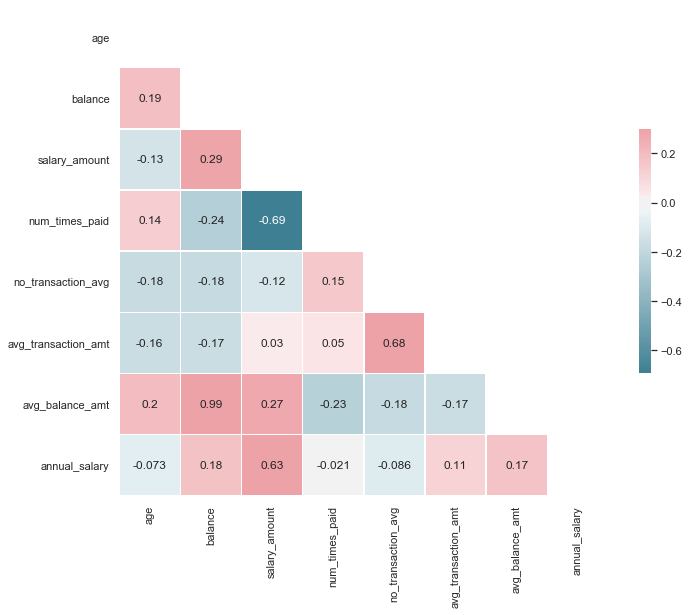

In [88]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_salary_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_salary_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [89]:
# From the above heatmap we can see that some of the derived attributes have some strong relationship with each other.
# annual_salary and salary_amount have a strong relationship with each other.
# num_times_paid and salary_amount have a negative strong relationship. This means that salary_amount is more for..
#..the customers who have been paid less number of times.

### 5.3 Correlation scatter plot

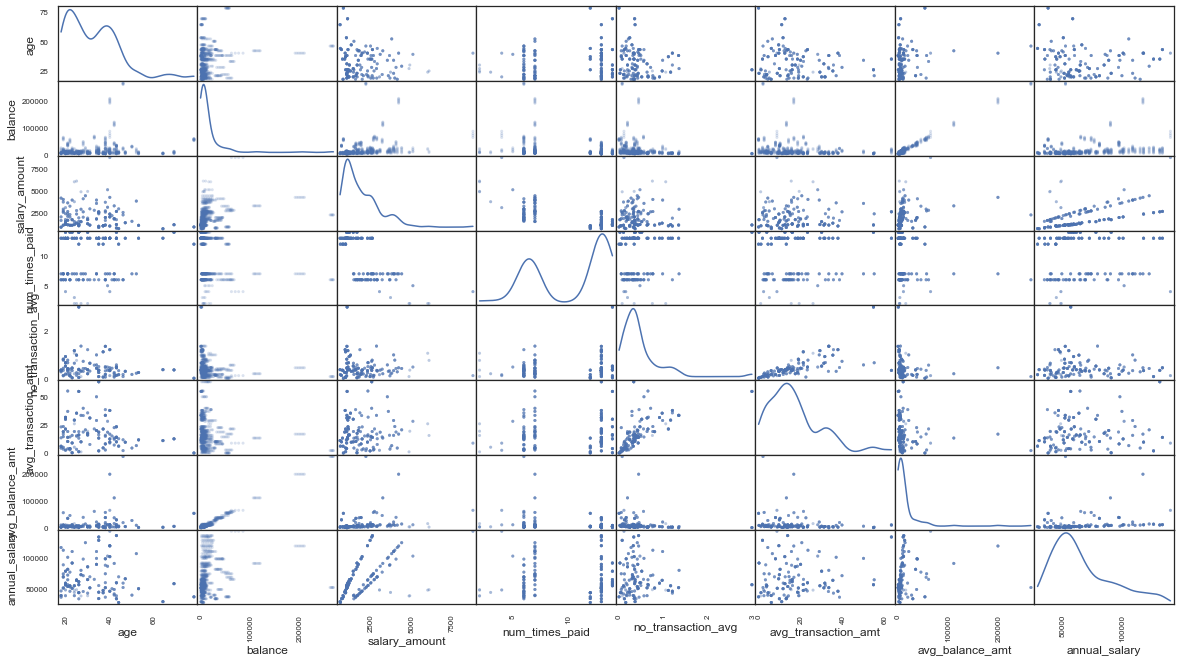

In [90]:
scatter_matrix(df_salary, alpha=0.2, figsize=(20, 11), diagonal='kde');

In [91]:
# # We can further group age column to gain more insight.
# # Group the "age" column
# age_group = []
# for age in df_salary["age"]:
#     if age < 25:
#         age_group.append("18-25")
#     elif 25 <= age <= 34:
#         age_group.append("25-34")
#     elif 34 < age <= 44:
#         age_group.append("35-44")
#     elif 44 < age <= 54:
#         age_group.append("45-54")
#     elif 54 < age <= 65:
#         age_group.append("55-64")
#     else:
#         age_group.append("65 and over")
        
# df_salary['age_group'] = age_group
# df_salary['age_group'] = df_salary['age_group'].astype('category')

## 6. One Hot Encoding <a class="anchor" id="sec_6"></a>

Categorical data is defined as variables with a finite set of label values. Most machine learning algorithms require numerical input and output variables. One hot encoding is used to convert categorical data to integer data.

In [92]:
# One hot encoding
# Copy the original data
df_salary_ohe = df_salary.copy()

In [93]:
df_salary_ohe = pd.get_dummies(df_salary_ohe, columns=['gender', 'state'])

In [94]:
df_salary_ohe.head()

,age,balance,salary_amount,num_times_paid,no_transaction_avg,avg_transaction_amt,avg_balance_amt,annual_salary,gender_F,gender_M,state_australian capital territory,state_new south wales,state_none,state_northern territory,state_queensland,state_south australia,state_tasmania,state_victoria,state_western australia
0,23,8342.11,3903.95,7,0.32,15.69,13368.37,109310.60,0,1,0,1,0,0,0,0,0,0,0
1,23,2040.58,1626.48,14,0.02,0.21,9740.26,91082.88,1,0,0,0,0,0,0,0,0,1,0
2,22,3158.51,983.36,14,0.10,3.91,6953.53,55068.16,0,1,0,1,0,0,0,0,0,0,0
3,24,2517.66,1408.08,7,0.63,19.14,3213.68,39426.24,0,1,0,0,0,0,0,0,0,1,0
4,43,2271.79,1068.04,14,0.47,23.35,5210.58,59810.24,1,0,0,0,0,0,0,0,0,1,0


## 7. Linear regression model <a class="anchor" id="sec_7"></a>

In [95]:
# Set up the dependent and the independent variables
X = pd.DataFrame(df_salary_ohe.loc[:,df_salary_ohe.columns != 'annual_salary'])
y = pd.DataFrame(df_salary_ohe.loc[:,['annual_salary']])

In [96]:
X.head()

,age,balance,salary_amount,num_times_paid,no_transaction_avg,avg_transaction_amt,avg_balance_amt,gender_F,gender_M,state_australian capital territory,state_new south wales,state_none,state_northern territory,state_queensland,state_south australia,state_tasmania,state_victoria,state_western australia
0,23,8342.11,3903.95,7,0.32,15.69,13368.37,0,1,0,1,0,0,0,0,0,0,0
1,23,2040.58,1626.48,14,0.02,0.21,9740.26,1,0,0,0,0,0,0,0,0,1,0
2,22,3158.51,983.36,14,0.10,3.91,6953.53,0,1,0,1,0,0,0,0,0,0,0
3,24,2517.66,1408.08,7,0.63,19.14,3213.68,0,1,0,0,0,0,0,0,0,1,0
4,43,2271.79,1068.04,14,0.47,23.35,5210.58,1,0,0,0,0,0,0,0,0,1,0


In [97]:
y.head()

,annual_salary
0,109310.60
1,91082.88
2,55068.16
3,39426.24
4,59810.24


In [98]:
# Divide the data into train and test sets; 80% train and 20% test

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [100]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(700, 18)
(176, 18)
(700, 1)
(176, 1)


In [101]:
scaler = preprocessing.StandardScaler()

In [102]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

In [103]:
# Train the algorithm

In [104]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [105]:
# Having a look at the coefficients that the model has chosen

In [106]:
v = pd.DataFrame(regressor.coef_, index=["Co-efficient"]).transpose()
w = pd.DataFrame(X.columns, columns=['Attribute'])

In [107]:
df_coeff = pd.concat([w,v], join='inner', axis=1)

In [108]:
df_coeff

,Attribute,Co-efficient
0,age,-1416.582222
1,balance,-11051.149081
2,salary_amount,30124.942853
3,num_times_paid,21601.791638
4,no_transaction_avg,-4640.596704
5,avg_transaction_amt,4050.742263
6,avg_balance_amt,11835.816185
7,gender_F,-496.635836
8,gender_M,496.635836
9,state_australian capital territory,235.295090


In [109]:
# Comparing the predicted value to the actual value

In [110]:
y_pred = regressor.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted'])

In [111]:
result = pd.concat([y_test.reset_index(drop=1),y_pred.reset_index(drop=1)], axis=1).reset_index(drop=True)

In [112]:
result

,annual_salary,Predicted
0,100202.20,93817.968905
1,72041.48,65093.279908
2,68513.76,63096.055442
3,74126.64,68435.924604
4,79524.20,59198.163812
5,64856.40,70704.155419
6,106001.84,84438.160627
7,58414.72,65834.016187
8,98493.08,97711.556368
9,102070.20,118727.704758


In [113]:
# Evaluate the algorithm by printing the metrics

In [114]:
print('Mean Absolute Error: ', metrics.mean_absolute_error(y_test,y_pred))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Mean Absolute Error:  8698.506506837997
Mean Squared Error:  188399234.72702596
Root Mean Squared Error:  13725.860072397138


In [115]:
# RMSE of the linear regression model is 13725. It means on average our salary prediction is varying by $13,725.86

## 8. Decision tree regressor model <a class="anchor" id="sec_8"></a>

In [116]:
# Divide the data into train and test sets

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

In [118]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(700, 18)
(176, 18)
(700, 1)
(176, 1)


In [119]:
scaler = preprocessing.StandardScaler()

In [120]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

In [121]:
tree_regressor = DecisionTreeRegressor(criterion="mse", max_depth = 3, random_state=1234)

In [122]:
tree_reg = tree_regressor.fit(X_train, y_train)

In [123]:
y_pred = tree_regressor.predict(X_test)

In [124]:
y_pred = pd.DataFrame(y_pred, columns=['Predicted'])

In [125]:
result_tree = pd.concat([y_test.reset_index(drop=1),y_pred.reset_index(drop=1)], axis=1).reset_index(drop=True)

In [126]:
result_tree

,annual_salary,Predicted
0,85991.92,67952.401176
1,46388.68,45460.944727
2,36986.88,44399.223111
3,98493.08,99998.242857
4,63717.16,65649.718806
5,39589.16,33953.060339
6,39379.92,44399.223111
7,44004.00,45460.944727
8,88992.28,65649.718806
9,101221.64,65649.718806


In [127]:
print('Mean Absolute Error: ', metrics.mean_absolute_error(y_test,y_pred))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Mean Absolute Error:  8614.767282773248
Mean Squared Error:  155473875.42962024
Root Mean Squared Error:  12468.91636950141


In [128]:
# RMSE of the decision tree regression model is 12468. It means on average our salary prediction is varying by $12,468.91

### 8.1 Decision tree visualisation

In [129]:
# Extract Column Names as List in Pandas Dataframe
data_feature_names = X.columns.tolist()

In [130]:
text_representation = tree.export_text(tree_regressor)
print(text_representation)

|--- feature_2 <= 0.31
|   |--- feature_2 <= -0.79
|   |   |--- feature_2 <= -0.90
|   |   |   |--- value: [33953.06]
|   |   |--- feature_2 >  -0.90
|   |   |   |--- value: [45460.94]
|   |--- feature_2 >  -0.79
|   |   |--- feature_3 <= -0.11
|   |   |   |--- value: [44399.22]
|   |   |--- feature_3 >  -0.11
|   |   |   |--- value: [65649.72]
|--- feature_2 >  0.31
|   |--- feature_3 <= -0.11
|   |   |--- feature_2 <= 1.13
|   |   |   |--- value: [67952.40]
|   |   |--- feature_2 >  1.13
|   |   |   |--- value: [99998.24]
|   |--- feature_3 >  -0.11
|   |   |--- feature_10 <= 0.51
|   |   |   |--- value: [131686.17]
|   |   |--- feature_10 >  0.51
|   |   |   |--- value: [118578.72]



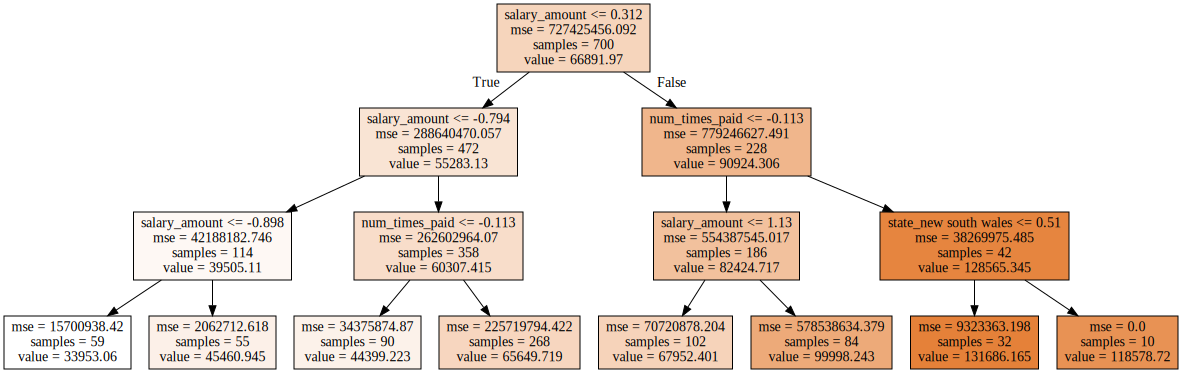

In [131]:
dot_data = tree.export_graphviz(tree_regressor, out_file=None, 
                                feature_names=data_feature_names,  
                                filled=True)
graphviz.Source(dot_data, format="png") 

## 9. Conclusion <a class="anchor" id="sec_9"></a>

After comparing the RMSE of Linear regression model and Decision tree regressor model we can conlcude that decision tree model has performed slightly better than the linear regression model in predicting the annual salary.<br>
We can improve the accuracy of decision tree regressor model by increasing the maximum depth of the model, this will definitely improve the accuracy of the model but we will risk overfitting the model on the data. So, when new data is presented to the model it may not perform as well as it has during training and testing.